Here's practice using the pavement images from the dataset given.

Starting with importing the necessary libraries

In [ ]:
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
import tensorflow as tf
import cv2 #opencv

from tensorflow import keras
from keras import layers
from keras.models import Sequential

from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#next is to load the dataset. I'll focus on the pavement images (so UP and CP)
from google.colab import drive
import PIL.Image
drive.mount('/content/drive', force_remount=True)

#the following is a condensed version of the image set from the zip folder. there are 99 images for each group (CP and UP)
c_images = os.chdir('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/CP')
u_images = os.chdir('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/UP')
c_path = '/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/CP'
u_path = '/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/UP'


Mounted at /content/drive


In [ ]:
#the distribution of these images will be equal because I've sampled from each group

import pathlib
c_list_data = list() # create a list for the c_image data
#read through it using a loop
for img in os.listdir(c_path):
  photo = cv2.imread(os.path.join(c_path, img)) #read the image
  photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB) #adjust the color to RGB
  photo = cv2.resize(photo, (80,80)) #these are large images, so let's resize them
  photo = np.array(photo) #convert into a list
  c_list_data.append([photo, 0]) #append to c_list
#c is going to be our 0, then u is 1
#do the same for the u_images
u_list_data = list()
for img in os.listdir(u_path):
  photo = cv2.imread(os.path.join(u_path, img))
  photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
  photo = cv2.resize(photo, (80,80))
  photo = np.array(photo)
  u_list_data.append([photo, 1])

#be careful when the saved file is put in those folders, it can mess with running certain areas of open cv. You might need to go back
#and delete those files in the folder that shows an error (when re-running this, it appeared in my UP folder)

#then the training set will be those images combined

training_set = c_list_data + u_list_data



In [ ]:
print(len(training_set))

198


In [ ]:
print(len(c_list_data))

99


That took a much shorter amount of time, so it works for now. Later on, I can try using larger and larger samples once training is the focus for our model.

Next, data visualization

In [ ]:
#convert list to numpy array

path = "/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P"
#save the list into an array

np.save(os.path.join(path, 'labels'), np.array(training_set, dtype=object))


In [ ]:
#reload
saved = np.load(os.path.join(path, 'labels.npy'), allow_pickle=True)

In [ ]:
#display the image
print(np.shape(saved))

data_rows = saved[:,0]
data_list=[]
print(np.shape(saved[0][0]))
for row in range(len(saved)):
  saved[row][0] = np.reshape(saved[row][0], (80*80*3))


(198, 2)
(80, 80, 3)


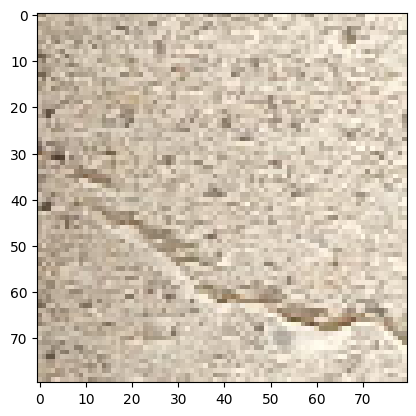

In [ ]:
plt.imshow(np.array(training_set[0][0]))

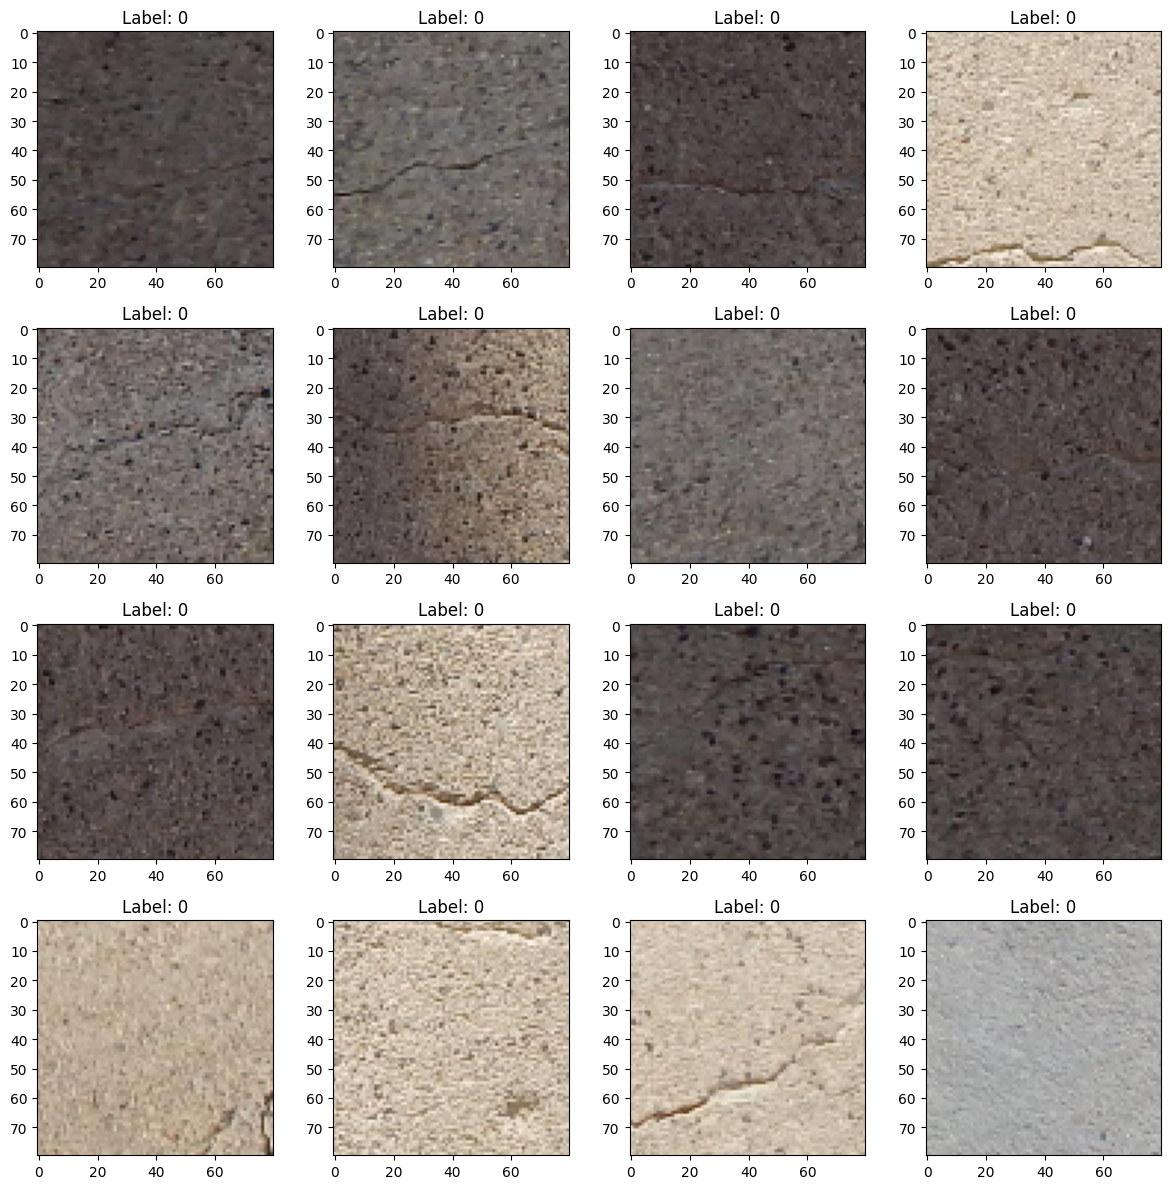

In [ ]:
#now to view a mix of the dataset
fig, axes = plt.subplots(4,4, figsize=(12,12))
img = 26
for row in range(4):
  for col in range(4):
    a = np.reshape(saved[img][0], (80,80,3))
    axes[row,col].imshow(a)
    axes[row,col].set_title("Label: " + str(saved[img][1]))
    img+=1
fig.tight_layout()


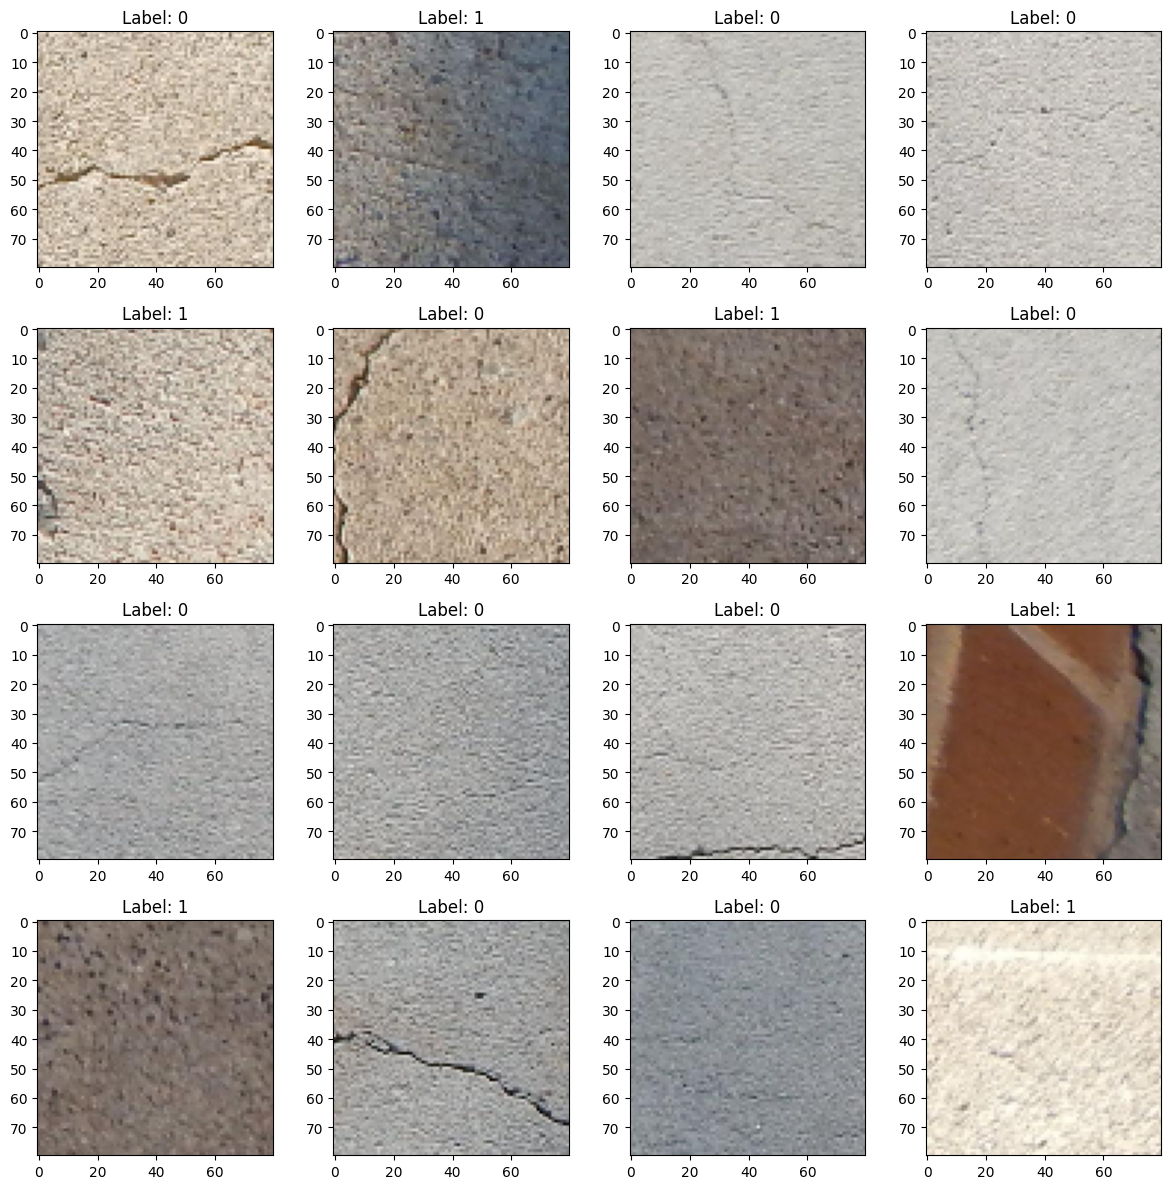

In [ ]:
#shuffle the c_images and u_images for training

np.random.shuffle(saved)

fig, axes = plt.subplots(4,4, figsize=(12,12))
img = 26
for row in range(4):
  for col in range(4):
    a = np.reshape(saved[img][0], (80,80,3))
    axes[row,col].imshow(a)
    axes[row,col].set_title("Label: " + str(saved[img][1]))
    img+=1
fig.tight_layout()

(array([  1,   2,   3,   4,   5,   6,   9,  12,  14,  16,  19,  21,  22,
        23,  24,  25,  27,  30,  32,  37,  38,  41,  43,  46,  47,  48,
        49,  51,  52,  53,  54,  55,  59,  60,  62,  66,  68,  69,  79,
        82,  84,  86,  87,  90,  94,  95,  97, 101, 103, 106, 107, 108,
       111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 126, 127,
       129, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 150, 152,
       153, 155, 157, 158, 159, 160, 161, 163, 164, 168, 172, 177, 180,
       181, 183, 184, 188, 189, 191, 195, 197]),)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17]


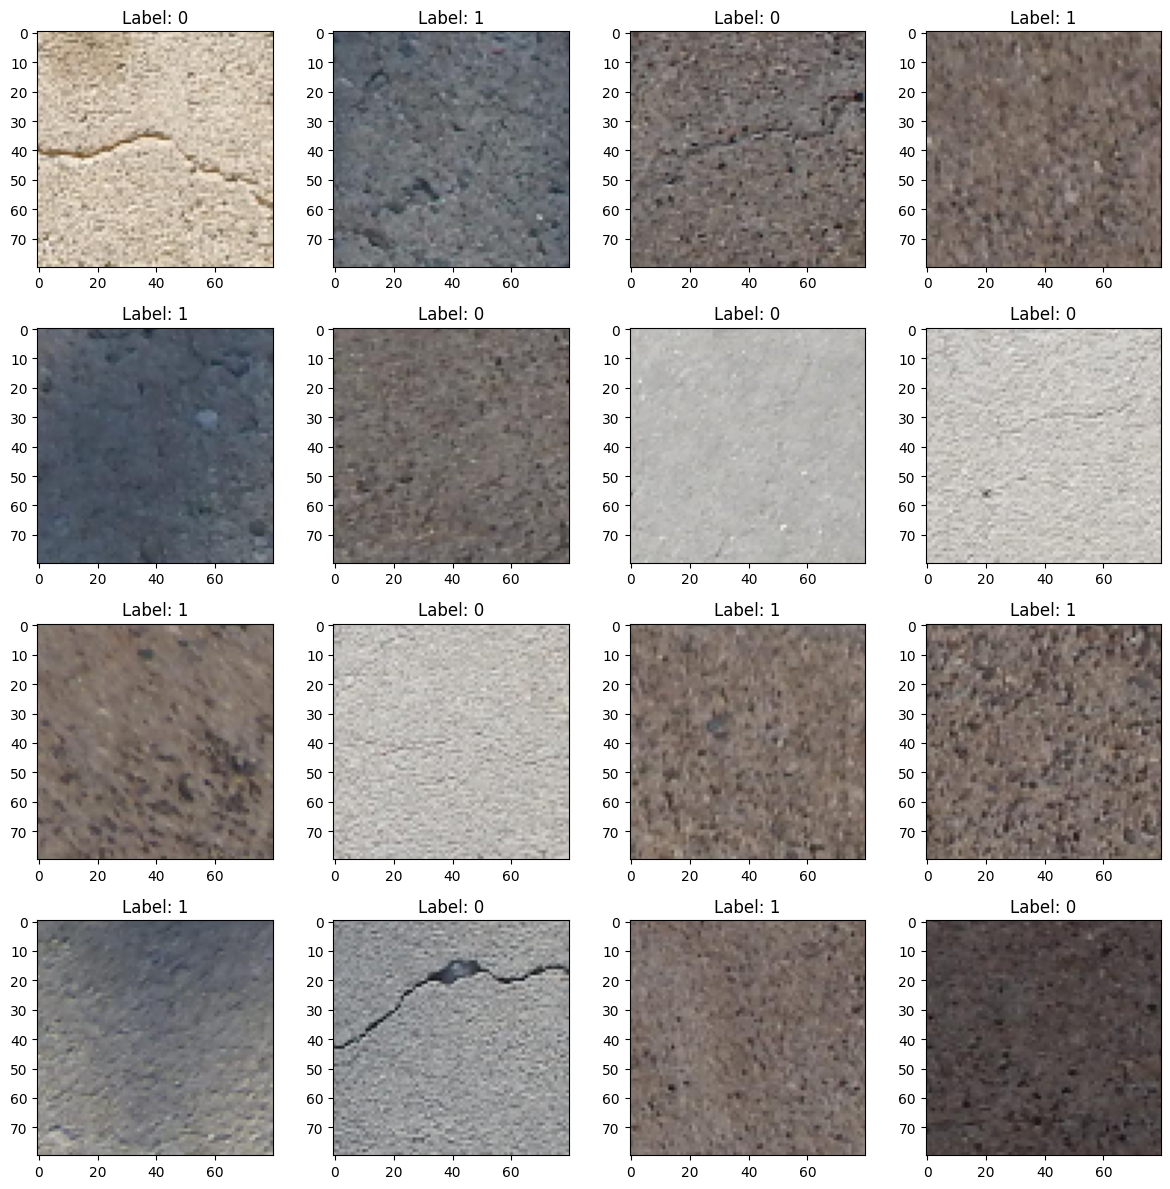

In [ ]:
print(np.where(saved[:,1]==1))

#train on 99 with 0, 99 with 1
#test on 50 with 0, test on 50 with 1

i = 0
j = 0
ix = 0
training = []
indices = []

while (i<8) or (j<8):
  if i < 8 and saved[ix][1] == 0:
    training.append(saved[ix])
    indices.append(ix)
    i+=1
  if j < 8 and saved[ix][1] == 1:
    training.append(saved[ix])
    indices.append(ix)
    j+=1
  ix += 1

np.random.shuffle(training)

fig, axes = plt.subplots(4,4, figsize=(12,12))
img = 0
for row in range(4):
  for col in range(4):
    a = np.reshape(training[img][0], (80,80,3))
    axes[row,col].imshow(a)
    axes[row,col].set_title("Label: " + str(training[img][1]))
    img+=1

fig.tight_layout()
print(indices)



In [ ]:
#to create the training and test data, we have to append them to respective arrays

#here's the test data for X and y
print(np.shape(saved))
test = np.delete(saved, indices, 0)
test_data = []
i = 0
j = 0
ix = 0
indices
while (i<5) or (j<5):
  if i < 5 and test[ix][1] == 0:
    test_data.append(test[ix])
    indices.append(ix)
    i+=1
  if j < 5 and test[ix][1] == 1:
    test_data.append(test[ix])
    indices.append(ix)
    j+=1
  ix += 1

#now the training
training = np.array(training)

X_train = training[:,0]
print(np.shape(X_train))
Y_train = training[:,1]
test_data = np.array(test_data)
X_test = test_data[:,:2]
Y_test = test_data[:,1]
print(Y_train)
print(Y_test)
print(X_train)

(198, 2)
(16,)
[0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0]
[1 1 0 1 0 1 1 0 0 0]
[array([212, 201, 181, ..., 230, 217, 198], dtype=uint8)
 array([ 79,  88, 101, ...,  60,  64,  73], dtype=uint8)
 array([101,  90,  88, ..., 116, 106,  97], dtype=uint8)
 array([116, 104, 101, ..., 108,  95,  87], dtype=uint8)
 array([107, 110, 119, ...,  97, 102, 111], dtype=uint8)
 array([117, 107, 105, ..., 100,  95,  93], dtype=uint8)
 array([186, 185, 183, ..., 173, 172, 168], dtype=uint8)
 array([179, 178, 174, ..., 190, 187, 182], dtype=uint8)
 array([126, 116, 106, ..., 101,  90,  88], dtype=uint8)
 array([171, 167, 164, ..., 203, 199, 196], dtype=uint8)
 array([121, 111, 104, ..., 135, 122, 115], dtype=uint8)
 array([ 85,  72,  64, ..., 101,  88,  80], dtype=uint8)
 array([118, 118, 123, ..., 184, 184, 173], dtype=uint8)
 array([136, 137, 141, ..., 181, 183, 182], dtype=uint8)
 array([125, 111, 108, ..., 139, 128, 124], dtype=uint8)
 array([78, 68, 67, ..., 88, 78, 77], dtype=uint8)]


In [ ]:
print(np.shape(X_train))

data_list = []
for row in X_train:
  data_list.append(row)
X_train = np.array(data_list)

print(np.shape(X_train))

data_list = []
for row in Y_train:
  data_list.append(row)
Y_train = np.array(data_list)

print(np.shape(Y_train))

print(np.shape(X_test))

data_list = []
for row in X_test:
  data_list.append(row[0])
X_test = np.array(data_list)

print(np.shape(X_test))

data_list = []
for row in Y_test:
  data_list.append(row)
Y_test = np.array(data_list)

print(np.shape(Y_test))


(16,)
(16, 19200)
(16,)
(10, 2)
(10, 19200)
(10,)


In [ ]:
#now to create a model to use as a baseline
#cifar10 used the sequential model, so I'll do the same
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(80,80,3)),
  #layers for the convulational kernel to produce tensor outputs (conv2d) and to downsample the input along its spatial dimensions (maxpooling2d)
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#there were some problems fitting this with the training set, so I'll circle back to this one another time


In [ ]:
#padding, use this cell for future code related to the sequential model

#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#let's experiment using nearestcentroid
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

clf = NearestCentroid()
clf.fit(X_train, Y_train)
train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)
print("Train Error", 1-accuracy_score(Y_train, train_predict))
print("Test Error: ", 1-accuracy_score(Y_test, test_predict))

Train Error 0.1875
Test Error:  0.09999999999999998


In [ ]:
print(Y_train)
print(train_predict)
print(Y_test)
print(test_predict)

[0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0]
[0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1]
[1 1 0 1 0 1 1 0 0 0]
[1 1 0 0 0 1 1 0 0 0]


In [ ]:
#save the model using pickle
import pickle
filename = "pavement_classifier.sav"
pickle.dump(clf, open(filename, 'wb'))


In [ ]:
#optimize using MLPClassifier

from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier((124,16,8), activation='tanh', solver='adam')
mlp_clf.fit(X_train, Y_train)
train_predict = mlp_clf.predict(X_train)
test_predict = mlp_clf.predict(X_test)
print("Train Error", 1-accuracy_score(Y_train, train_predict))
print("Test Error: ", 1-accuracy_score(Y_test, test_predict))
filename = "mlp_classifier.sav"
pickle.dump(mlp_clf, open(filename, 'wb'))

Train Error 0.5
Test Error:  0.5


Sklearn Results:
--- Accuracy (train): 0.8125
--- Accuracy (test): 0.9


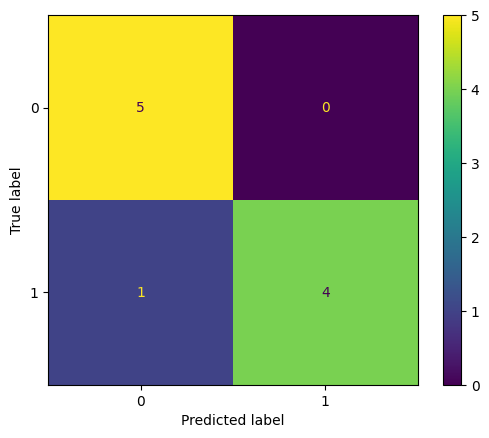

In [ ]:
sklearn_nearest_centroid = NearestCentroid()

# Fit on training dataset
sklearn_nearest_centroid.fit(X_train, Y_train)
# Make predictions on training and testing data
sklearn_y_pred_tr = sklearn_nearest_centroid.predict(X_train)
sklearn_y_pred_te = sklearn_nearest_centroid.predict(X_test)
# Evaluate accuracies using the sklearn function accuracy_score
sklearn_acc_tr = accuracy_score(Y_train, sklearn_y_pred_tr)
sklearn_acc_te = accuracy_score(Y_test, sklearn_y_pred_te)
print(f'Sklearn Results:')
print(f'--- Accuracy (train): {sklearn_acc_tr}')
print(f'--- Accuracy (test): {sklearn_acc_te}')
# Evaluate confusion matrix using the sklearn function confusion_matrix
sklearn_cm = confusion_matrix(Y_test, sklearn_y_pred_te)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot();

#something to note!! Increasing the pixel count from 50 to 80 increased the accuracy for both training and testing.
#for reference, I started with 50x50x3 and that had an accuracy of 0.5625(train) and 0.7(test) approximately